# Download ParaNMT Dataset and transform it

## Downloading data

In [1]:
import pandas as pd
import requests
import os
import zipfile

Required data set is in the GitHub repository, let's download it from the link and unzip it.

In [2]:
url = "https://github.com/skoltech-nlp/detox/releases/download/emnlp2021/filtered_paranmt.zip"
os.makedirs("../data/raw", exist_ok=True)
zip_filename = "../data/raw/filtered_paranmt.zip"

In [3]:
response = requests.get(url)
with open(zip_filename, "wb") as zip_file:
    zip_file.write(response.content)

In [4]:
with zipfile.ZipFile(zip_filename, "r") as zip_ref:
    with zip_ref.open("filtered.tsv") as file:
        df = pd.read_csv(file, sep='\t')

In [5]:
df.head()

,Unnamed: 0,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


Our dataframe consists of 

| Column | Type | Discription | 
| ----- | ------- | ---------- |
| reference | str | First item from the pair | 
| ref_tox | float | toxicity level of reference text | 
| translation | str | Second item from the pair - paraphrazed version of the reference|
| trn_tox | float | toxicity level of translation text |
| similarity | float | cosine similarity of the texts |
| lenght_diff | float | relative length difference between texts |

## Data visualisation 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577777 entries, 0 to 577776
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   577777 non-null  int64  
 1   reference    577777 non-null  object 
 2   translation  577777 non-null  object 
 3   similarity   577777 non-null  float64
 4   lenght_diff  577777 non-null  float64
 5   ref_tox      577777 non-null  float64
 6   trn_tox      577777 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 30.9+ MB


Based on the information in the table, there are no zero values, which means that processing of this case can be skipped. In the first 10 lines, the reference is less toxic than the translation, it’s bad to train a model on such data.
Let’s look at the statistics for the entire dataset

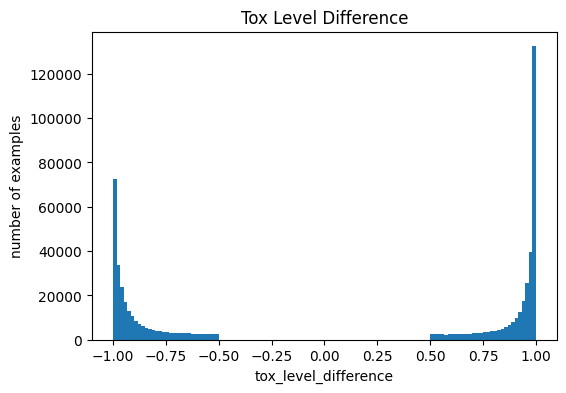

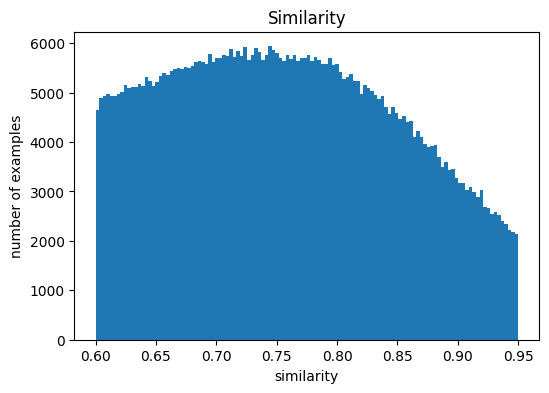

In [7]:
import matplotlib.pyplot as plt

df['great_trn'] = df['ref_tox']-df['trn_tox']
tox_level_difference = df['great_trn'].tolist()


similarity = df['similarity'].tolist()

n_bins=120
plt.figure(figsize=(6, 4))  # Создаем первый график
plt.ylabel('number of examples')
plt.xlabel('tox_level_difference')
plt.hist(tox_level_difference, bins=n_bins)
plt.title('Tox Level Difference')
plt.show()

plt.figure(figsize=(6, 4))  # Создаем второй график
plt.ylabel('number of examples')
plt.xlabel('similarity')
plt.hist(similarity, bins=n_bins)
plt.title('Similarity')
plt.show()

## Data preprocessing

Based on the presented graphs, we will select good data for training our model.
The *difference* in the toxicity level of the reference and translation must be **>=0.5** and the *similarity* of the strings must be **> 0.7**

In [15]:
filtered_df = df[(df['ref_tox'] - df['trn_tox'] >= 0.5) & (df['similarity'] > 0.7)]

We will also create a test dataframe, it seems to me that in it we only need the reference columns and the level of its toxicity.

In [16]:
test_df = df[~df.index.isin(filtered_df.index)& (df['ref_tox'] > 0.7)].head(5000)
test_df = test_df[["reference", "ref_tox"]]

In [17]:
filtered_df.to_csv('../data/interm/preprocessed_filtered.csv', index=False)
test_df.to_csv('../data/interm/test.csv', index=False)